### Time Series Energy Consumption Prediction using Machine Learning
#### Methods: XGBoost on hourly consumption data.

In [218]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [219]:
# import specific library.
import xgboost as xgb

In [221]:
# Create the style.
color_pal = sns.color_palette()
plt.style.use('Solarize_Light2')

In [223]:
# load the data.
df = pd.read_csv('PJME_hourly.csv')
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


#### Clean the Dataset

In [227]:
# What is the information of the data?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [229]:
# Change the index to Datetime.
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [231]:
# What does the data look like?
df.info()
df.head(2)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0


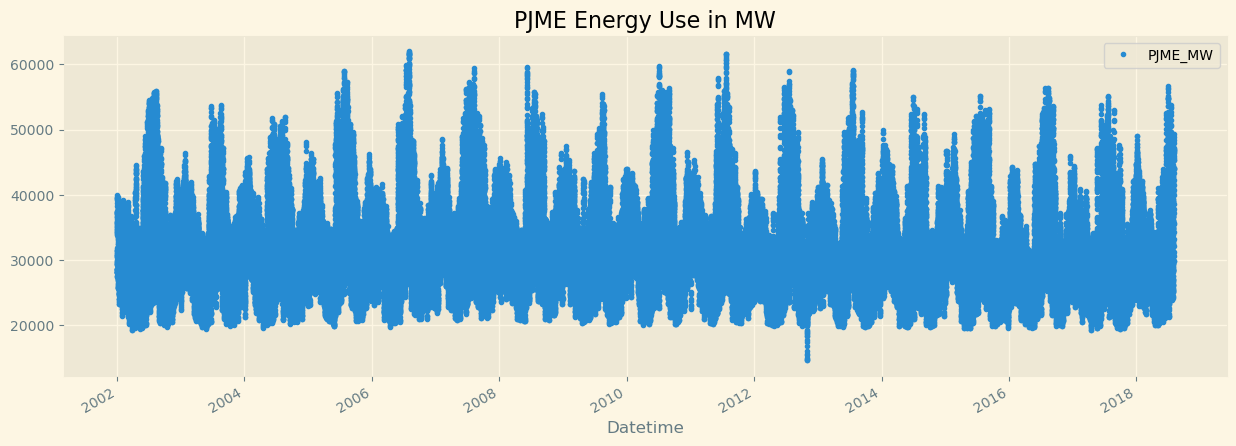

In [233]:
# Track the hourly usage.
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

#### Do we have any outliers to remove?

<Axes: ylabel='Frequency'>

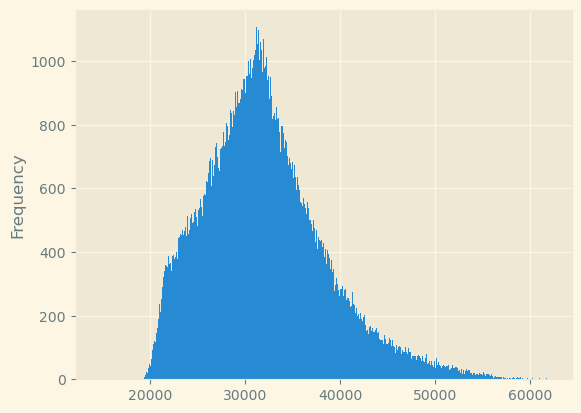

In [235]:
# Create a histogram.
df['PJME_MW'].plot(kind='hist', bins=500)

<Axes: xlabel='Datetime'>

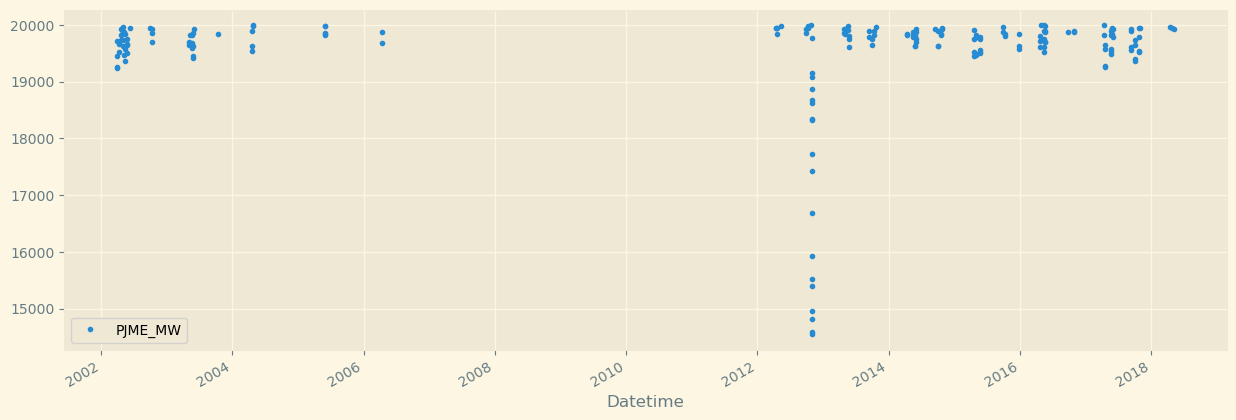

In [238]:
# Are there any outliers lower than 20K?
df.query('PJME_MW < 20_000').plot(figsize=(15,5), style='.')

In [240]:
# Clarify the the outliers even more.
#df.query('PJME_MW < 19_000').plot(figsize=(15,5), style='.')

In [242]:
# Generate a new df without the outliers.
# df= df.query('PJME_MW < 19_000').copy()

#### Review the datasets for a train and test split.

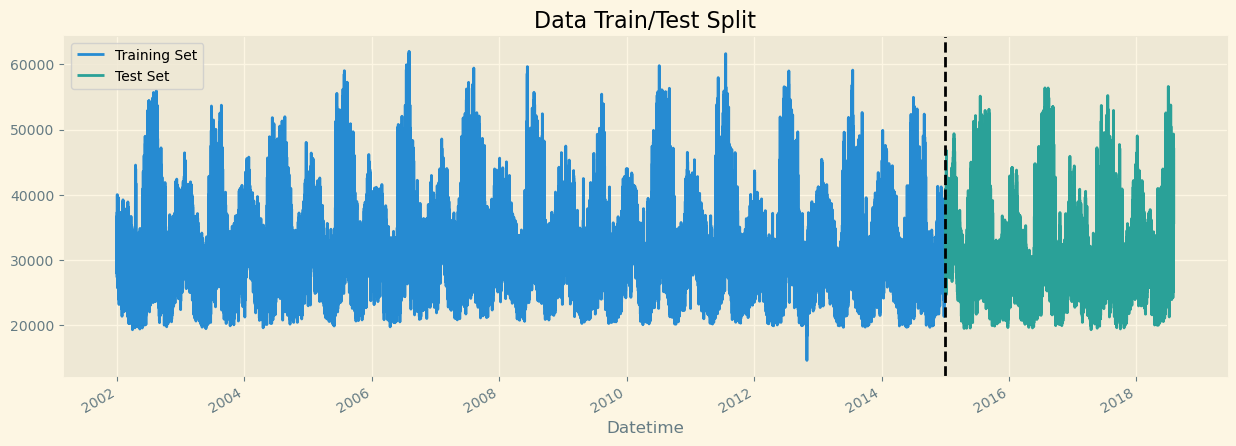

In [247]:
# Split the data between a manual train and testing period.
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

# Plot the split datasets.
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

### Create a Time Series Cross Validation

In [253]:
# import tools
from sklearn.model_selection import TimeSeriesSplit

# detail the parameters, gap of 24 hours betwen training set ends and test set begins.
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
# test size is 24 hours for 265 days every day. 

# sort the time series split 
df = df.sort_index()

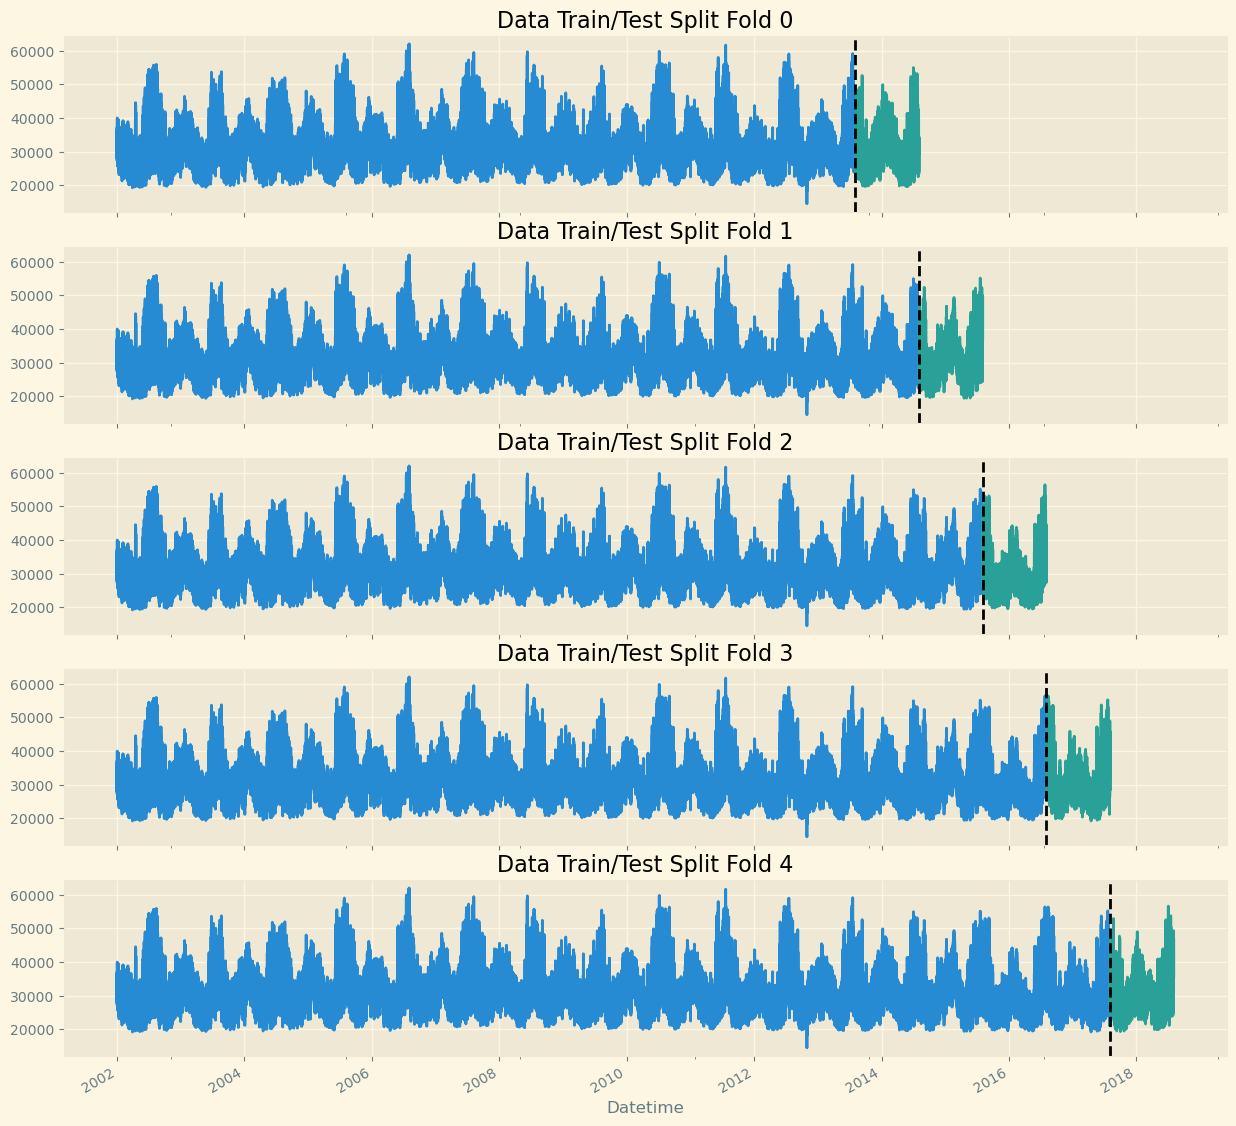

In [259]:
# visualise the training and testing splits.

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold = fold + 1
plt.show()

# test the last 5 years that is independently of each set. 

### Forecasting Horizon (How far into the future?)

In [262]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

### What are the lag features?

In [268]:
# Create a dictionary to map the features.
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df
    
# timedelta looks into the past from the datetime index. 364/7 works for same day of wk.

In [270]:
# Create a new data frame.
df = add_lags(df)

#### Train the Data using Cross-Validation.

In [277]:
# What are the lag features? 
df.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,2,31,36490.0,35406.0,34552.0
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0


In [279]:
# Create the training loop.
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

In [281]:
# Generate the conditions of the loop.
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32730.70639	validation_1-rmse:31956.68992


/home/90b273c2-2c9b-4ea9-b137-d2a70dc73cea/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:10:44] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12532.55336	validation_1-rmse:11909.41611
[200]	validation_0-rmse:5747.09818	validation_1-rmse:5364.37773
[300]	validation_0-rmse:3873.51430	validation_1-rmse:3899.82339
[400]	validation_0-rmse:3436.83821	validation_1-rmse:3761.31682
[471]	validation_0-rmse:3341.08977	validation_1-rmse:3765.71043
[0]	validation_0-rmse:32670.52224	validation_1-rmse:32138.89280


/home/90b273c2-2c9b-4ea9-b137-d2a70dc73cea/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:10:50] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12513.49682	validation_1-rmse:12224.28419
[200]	validation_0-rmse:5757.00363	validation_1-rmse:5660.61027
[300]	validation_0-rmse:3906.64261	validation_1-rmse:3931.54029
[400]	validation_0-rmse:3480.55395	validation_1-rmse:3594.18390
[500]	validation_0-rmse:3356.18631	validation_1-rmse:3521.16813
[600]	validation_0-rmse:3300.89593	validation_1-rmse:3485.23578
[700]	validation_0-rmse:3261.72962	validation_1-rmse:3464.90388
[800]	validation_0-rmse:3225.50605	validation_1-rmse:3438.64983
[900]	validation_0-rmse:3197.54901	validation_1-rmse:3430.10289
[999]	validation_0-rmse:3171.60041	validation_1-rmse:3423.30152
[0]	validation_0-rmse:32629.68486	validation_1-rmse:31073.29137


/home/90b273c2-2c9b-4ea9-b137-d2a70dc73cea/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:11:01] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12498.98688	validation_1-rmse:11138.63967
[200]	validation_0-rmse:5752.02891	validation_1-rmse:4816.91019
[300]	validation_0-rmse:3919.15626	validation_1-rmse:3552.07912
[400]	validation_0-rmse:3498.18633	validation_1-rmse:3492.18418
[0]	validation_0-rmse:32527.02577	validation_1-rmse:31475.38351


/home/90b273c2-2c9b-4ea9-b137-d2a70dc73cea/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:11:12] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12462.05865	validation_1-rmse:12020.44091
[200]	validation_0-rmse:5737.80165	validation_1-rmse:5797.76066
[300]	validation_0-rmse:3915.35694	validation_1-rmse:4384.39516
[400]	validation_0-rmse:3498.63311	validation_1-rmse:4169.62998
[500]	validation_0-rmse:3383.05051	validation_1-rmse:4111.26353
[551]	validation_0-rmse:3349.92041	validation_1-rmse:4113.13413
[0]	validation_0-rmse:32460.74594	validation_1-rmse:31463.90740


/home/90b273c2-2c9b-4ea9-b137-d2a70dc73cea/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:11:19] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12445.47503	validation_1-rmse:11959.11979
[200]	validation_0-rmse:5752.02184	validation_1-rmse:5613.55633
[300]	validation_0-rmse:3951.97347	validation_1-rmse:4156.62286
[400]	validation_0-rmse:3542.75274	validation_1-rmse:4008.30348
[436]	validation_0-rmse:3488.10069	validation_1-rmse:4006.43301


In [283]:
# What are the experimental scores?
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3754.6872
Fold scores:[3758.5256000579657, 3423.147857410298, 3476.121686141068, 4111.027693505075, 4004.6130268714915]


### Predict the Future.

In [288]:
# Retrain the dataset.
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32402.66145


/home/90b273c2-2c9b-4ea9-b137-d2a70dc73cea/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [00:12:21] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12426.65728
[200]	validation_0-rmse:5753.26464
[300]	validation_0-rmse:3973.71114
[400]	validation_0-rmse:3574.05442
[499]	validation_0-rmse:3459.67006


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [290]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [294]:
# Create the future dataframe.
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [296]:
future_w_features = df_and_future.query('isFuture').copy()

#### Predict the Future 

In [301]:
# Create the future.
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

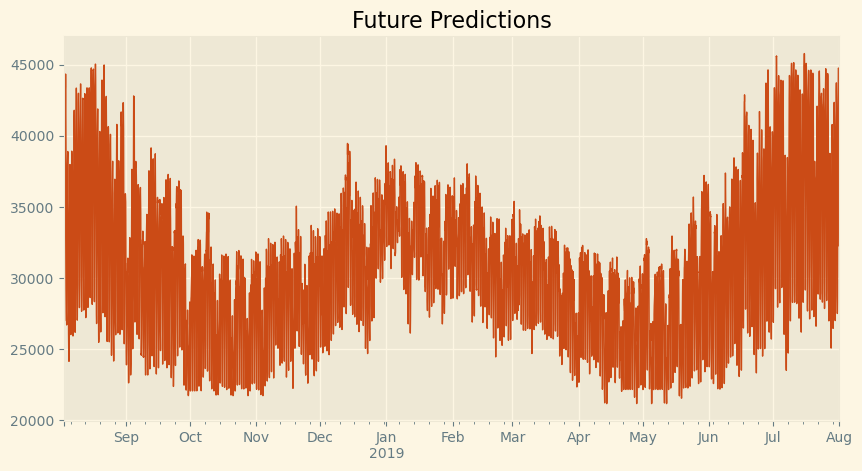

In [303]:
# Plot the future.
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

### Save the Model

In [306]:
# Save the model.
reg.save_model('model.json')

In [308]:
!ls -lh

total 7.6M
-rw-rw-r-- 1 90b273c2-2c9b-4ea9-b137-d2a70dc73cea registered_users 2.7M Nov  5 23:33 AEP_hourly.csv
-rw-rw-r-- 1 90b273c2-2c9b-4ea9-b137-d2a70dc73cea registered_users 528K Nov  6 00:15 Energy_TimesSeries.ipynb
-rw-rw-r-- 1 90b273c2-2c9b-4ea9-b137-d2a70dc73cea registered_users 3.9M Nov  5 23:34 PJME_hourly.csv
-rw-rw-r-- 1 90b273c2-2c9b-4ea9-b137-d2a70dc73cea registered_users 559K Nov  6 00:16 model.json


<Axes: title={'center': 'Future Predictions'}>

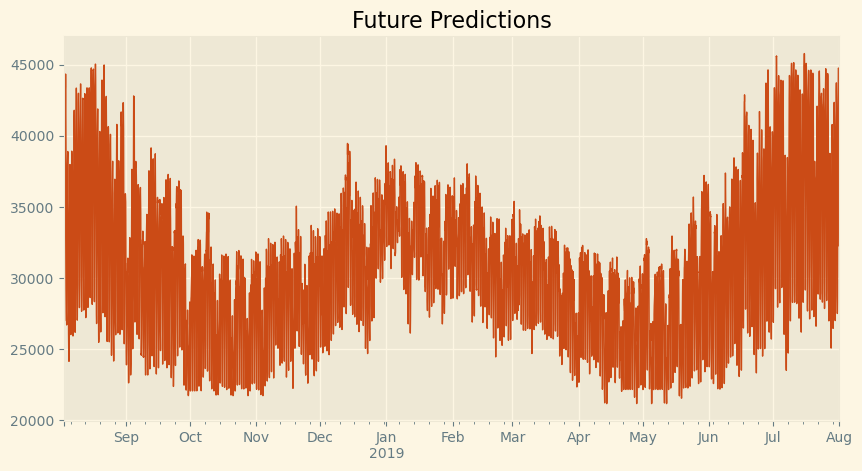

In [310]:
# Create the future model.
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')